In [34]:
import pandas as pd
df = pd.read_csv('S06-hw-dataset-01.csv')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve, auc,
    classification_report)

In [36]:
print(df.head())
print('информация')
print(df.info())
print('описание')
print(df.describe())

print(df['target'].value_counts())
print(df.isnull().sum())

X = df.drop(columns=['target', 'id'])
y = df['target']

print(X.shape)
print(y.shape)
print('Классы', np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.2,
    stratify=y,
    random_state = 42
)

print('x \n', x_train)
print('y \n', y_train)

   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.537345  ... -2.183407 -2.896590  2.440343 -1.097168  1.457323   

   cat_contract  cat_region  cat_payment  te

In [37]:
baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline.fit(x_train, y_train)
b_predict = baseline.predict(x_test)

accuracy_b = accuracy_score(b_predict, y_test)
f1_b = f1_score(b_predict, y_test)
print('baseline', 'acc =', accuracy_b, 'f1 =', f1_b)

logreg_pip = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg',LogisticRegression(random_state=42, max_iter=1000))])
logreg_pip.fit(x_train, y_train)
logreg_predict = logreg_pip.predict(x_test)

accuracy_logreg = accuracy_score(logreg_predict, y_test)
f1_logreg = f1_score(logreg_predict, y_test)
print('logreg', 'acc =', accuracy_logreg, 'f1 =', f1_logreg)
logreg_proba = logreg_pip.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, logreg_proba)
print('roc_auc =', roc_auc)

baseline acc = 0.6766666666666666 f1 = 0.0
logreg acc = 0.8275 f1 = 0.7076271186440678
roc_auc = 0.8746905312071505


In [38]:
# DecisionTree
dt_params = {
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid.fit(x_train, y_train)
dt_best = dt_grid.best_estimator_

# RandomForest
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(x_train, y_train)
rf_best = rf_grid.best_estimator_

# GradientBoosting
gb_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_leaf': [1, 3]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy', n_jobs=-1)
gb_grid.fit(x_train, y_train)
gb_best = gb_grid.best_estimator_

# Stacking
base_models = [
    ('dt', dt_best),
    ('rf', rf_best),
    ('gb', gb_best)]
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    cv=5,
    n_jobs=-1)
stacking.fit(x_train, y_train)

models = {
    'DecisionTree': dt_best,
    'RandomForest': rf_best,
    'GradientBoosting': gb_best,
    'Stacking': stacking}

for name, model in models.items():
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(name, 'Accuracy =', acc)

DecisionTree Accuracy = 0.8675
RandomForest Accuracy = 0.9279166666666666
GradientBoosting Accuracy = 0.935
Stacking Accuracy = 0.9345833333333333


Метрики качества
DecisionTree:
  Accuracy: 0.8675
  F1-score: 0.7857
  ROC-AUC:  0.8982

RandomForest:
  Accuracy: 0.9279
  F1-score: 0.8829
  ROC-AUC:  0.9670

GradientBoosting:
  Accuracy: 0.9350
  F1-score: 0.8964
  ROC-AUC:  0.9707

Stacking:
  Accuracy: 0.9346
  F1-score: 0.8962
  ROC-AUC:  0.9704



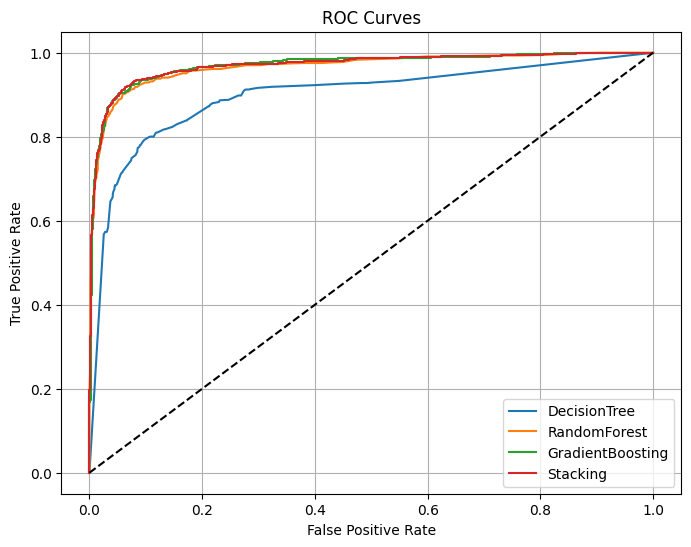

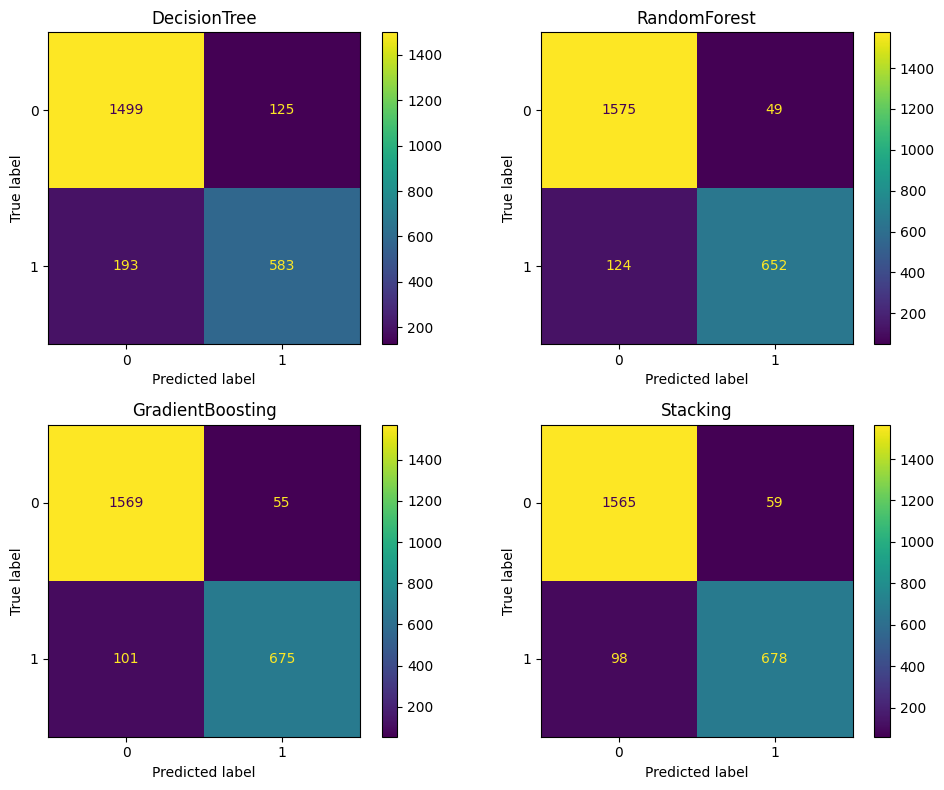

In [41]:
print("Метрики качества")

for name, model in models.items():
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)  # бинарная классификация

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-score: {f1:.4f}")

    # ROC-AUC для моделей с вероятностями
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(x_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"  ROC-AUC:  {roc_auc:.4f}")
    print()

# ROC-кривые
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(x_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix для всех моделей
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for (name, model), ax in zip(models.items(), axes.ravel()):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()

Лучшая модель: GradientBoosting (ROC-AUC = 0.9707)
num18: 0.0729
num19: 0.0649
num07: 0.0349
num04: 0.0177
num24: 0.0145
num20: 0.0124
num01: 0.0100
num14: 0.0090
num22: 0.0076
num16: 0.0064


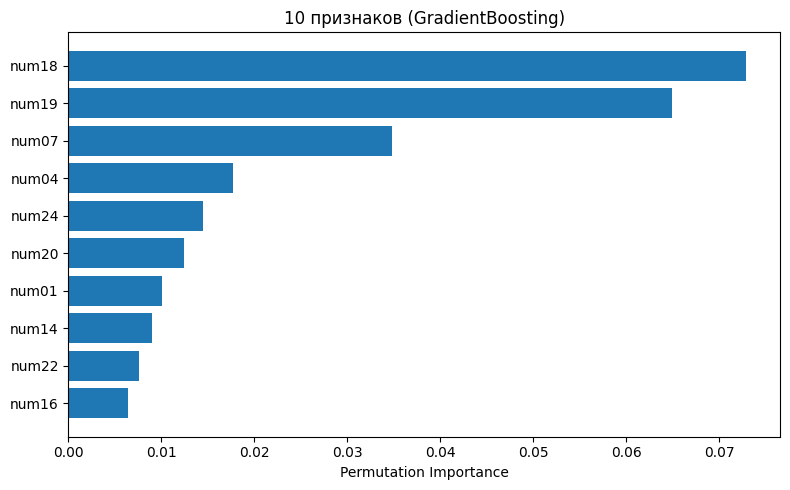

In [43]:
from sklearn.inspection import permutation_importance

# Определяем лучшую модель по ROC-AUC
best_model_name = None
best_score = 0

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(x_test)[:, 1]
        score = roc_auc_score(y_test, y_proba)
        if score > best_score:
            best_score = score
            best_model_name = name

best_model = models[best_model_name]
print(f"Лучшая модель: {best_model_name} (ROC-AUC = {best_score:.4f})")

result = permutation_importance(
    best_model, x_test, y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc'
)

importances = result.importances_mean
indices = np.argsort(importances)[::-1][:10]

for idx in indices:
    print(f"{x_train.columns[idx]}: {importances[idx]:.4f}")

plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[indices][::-1])
plt.yticks(range(10), [x_train.columns[i] for i in indices[::-1]])
plt.xlabel('Permutation Importance')
plt.title(f'10 признаков ({best_model_name})')
plt.tight_layout()
plt.show()

Интерпретация результатов permutation importance

Наиболее важными признаками для модели GradientBoosting являются:

num18 - важность: 0.0729

num19 - важность: 0.0649

num07 - важность: 0.0349

num04 - важность: 0.0177

num24 - важность: 0.0145

num20 - важность: 0.0124

num01 - важность: 0.0100

num14 - важность: 0.0090

num22 - важность: 0.0076

num16 - важность: 0.0064

num18 и num19 значительно важнее других признаков (в 2-5 раз), что указывает на их ключевую роль в предсказаниях модели.

Важность признаков резко падает после первых двух, что характерно для бустинговых моделей - они фокусируются на наиболее информативных признаках.

GradientBoosting показал лучший ROC-AUC (0.9707), что согласуется с тем, что бустинг хорошо работает на табличных данных и эффективно использует наиболее информативные признаки.